In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import takewhile
from astropy.table import Table

# 1) Load COSMOSSNAP catalog

In [2]:
def read_cosmossnap_photometry_file(filename):
    # Get column names from header
    with open(filename, 'r') as fobj:
        headiter = takewhile(lambda s: s.startswith('#'), fobj)
        colnames = [elem.split()[2] for elem in headiter]
    # Open with pandas
    photometry = pd.read_csv(filename, delim_whitespace=True, comment="#", names=colnames)
    return photometry

In [3]:
filename = "../data/2016-06-22_cosmossnap_photometry.out"
%time photometry = read_cosmossnap_photometry_file(filename)

/Users/brunomor/anaconda/lib/python2.7/site-packages/IPython/core/magic.py:193: DtypeWarning: Columns (11,16,21,26,31,36,41,46,51,56,61,66,71,76,81,86,91,96,101,106) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 18.2 s, sys: 1.6 s, total: 19.8 s
Wall time: 20.2 s


In [4]:
print(photometry.columns.values)

['Id' 'SpcExt' 'type' 'Mod' 'z' 'E(B-V)' 'DMz' 'MNUV' 'Mstar'
 'Half_light_radius' 'ROII' 'Mabs_des_g' 'Mapp_des_g' 'Msed_des_g'
 'Ran_des_g' 'Err_des_g' 'Mabs_des_r' 'Mapp_des_r' 'Msed_des_r' 'Ran_des_r'
 'Err_des_r' 'Mabs_des_i' 'Mapp_des_i' 'Msed_des_i' 'Ran_des_i' 'Err_des_i'
 'Mabs_des_z' 'Mapp_des_z' 'Msed_des_z' 'Ran_des_z' 'Err_des_z'
 'Mabs_des_y' 'Mapp_des_y' 'Msed_des_y' 'Ran_des_y' 'Err_des_y'
 'Mabs_euclid_vis' 'Mapp_euclid_vis' 'Msed_euclid_vis' 'Ran_euclid_vis'
 'Err_euclid_vis' 'Mabs_euclid_J' 'Mapp_euclid_J' 'Msed_euclid_J'
 'Ran_euclid_J' 'Err_euclid_J' 'Mabs_euclid_H' 'Mapp_euclid_H'
 'Msed_euclid_H' 'Ran_euclid_H' 'Err_euclid_H' 'Mabs_euclid_Y'
 'Mapp_euclid_Y' 'Msed_euclid_Y' 'Ran_euclid_Y' 'Err_euclid_Y'
 'Mabs_lsst_u' 'Mapp_lsst_u' 'Msed_lsst_u' 'Ran_lsst_u' 'Err_lsst_u'
 'Mabs_lsst_g' 'Mapp_lsst_g' 'Msed_lsst_g' 'Ran_lsst_g' 'Err_lsst_g'
 'Mabs_lsst_r' 'Mapp_lsst_r' 'Msed_lsst_r' 'Ran_lsst_r' 'Err_lsst_r'
 'Mabs_lsst_i' 'Mapp_lsst_i' 'Msed_lsst_i' 'Ran_lsst_i' '

# 2) Applying sensible cuts for the scientific analysis

In [5]:
mask = (photometry["Ran_lsst_i"] < 25.3) # i-band magnitude cut for LSST 'Gold' sample
mask = mask & (photometry["Ran_lsst_i"] > 18.0) # i-band magnitude sanity cut - trivial
mask = mask & (photometry["Err_lsst_i"] < 0.1086) # S/N > 10 in the i-band magnitude
mask = mask & ((0.03*photometry['Half_light_radius']) >= 0.1) # Size cut to exclude misclassified stars or quasars: 0.1 arcseconds

In [7]:
photometry = photometry[mask]
print(len(photometry))

218966


# 3) Checking a few basic properties

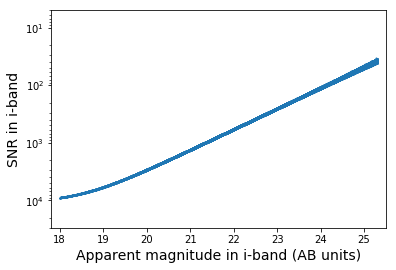

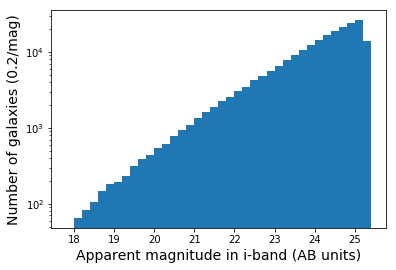

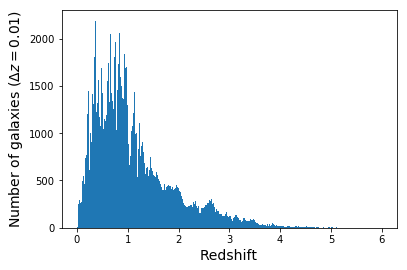

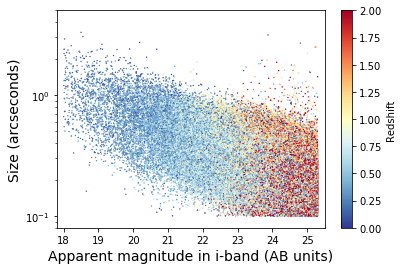

In [8]:
plt.figure()
plt.plot(photometry["Ran_lsst_i"], 1.086/photometry["Err_lsst_i"], ".", markersize=2)
plt.xlim(17.8, 25.5)
plt.yscale("log")
plt.ylim(3e4, 5)
plt.xlabel("Apparent magnitude in i-band (AB units)", fontsize=14)
plt.ylabel("SNR in i-band", fontsize=14)

plt.figure()
_ = plt.hist(photometry["Ran_lsst_i"], bins=np.arange(17.8, 25.5, 0.2))
plt.xlabel("Apparent magnitude in i-band (AB units)", fontsize=14)
plt.ylabel("Number of galaxies (0.2/mag)", fontsize=14)
plt.yscale("log")

plt.figure()
_ = plt.hist(photometry["z"], bins=np.arange(0, 6, 0.01))
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Number of galaxies ($\Delta z=0.01$)", fontsize=14)

plt.figure()
plt.scatter(photometry["Ran_lsst_i"], 0.03*photometry['Half_light_radius'], c=photometry["z"],
            cmap=plt.cm.RdYlBu_r, vmin=0, vmax=2, s=2, lw=0)
plt.xlim(17.8, 25.5)
plt.ylim(0.08, 5)
plt.xlabel("Apparent magnitude in i-band (AB units)", fontsize=14)
plt.ylabel("Size (arcseconds)", fontsize=14)
plt.yscale("log")
plt.colorbar(label="Redshift")

# 4) Selecting columns, renaming and saving file

In [9]:
lsst = photometry[["Id", "SpcExt", "z", "Ran_lsst_u", "Ran_lsst_g", "Ran_lsst_r", "Ran_lsst_i", "Ran_lsst_z", "Ran_lsst_y"]]
lsst.rename(columns={"z": "redshift", "Ran_lsst_u": "mag_lsst_u", "Ran_lsst_g": "mag_lsst_g",
                     "Ran_lsst_r": "mag_lsst_r", "Ran_lsst_i": "mag_lsst_i",
                     "Ran_lsst_z": "mag_lsst_z", "Ran_lsst_y": "mag_lsst_y"}, inplace=True)

/Users/brunomor/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [17]:
lsst.to_csv("../data/2017-12-06_LSST_photometry.csv", index=False)

# 5) Appendix: Some weird-colored objects are not weird at all: They're Lyman Break Galaxies (LGBs)

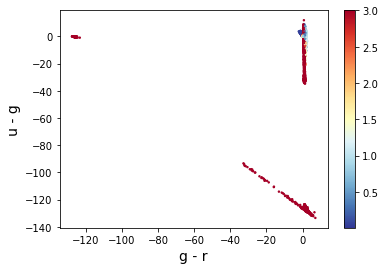

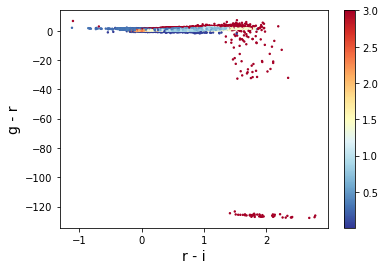

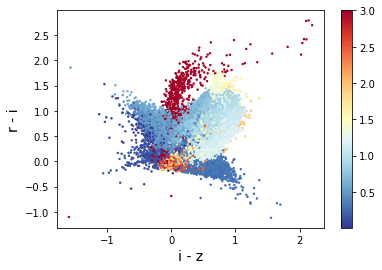

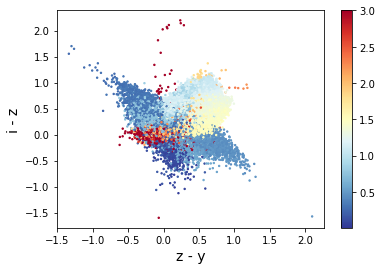

In [11]:
for band1, band2, band3 in zip("ugri", "griz", "rizy"):
    plt.figure()
    plt.scatter(lsst["mag_lsst_" + band2] - lsst["mag_lsst_" + band3],
                lsst["mag_lsst_" + band1] - lsst["mag_lsst_" + band2],
                c=lsst["redshift"], s=2, vmax=3, cmap=plt.cm.RdYlBu_r)
    plt.xlabel("%s - %s" % (band2, band3), fontsize=14)
    plt.ylabel("%s - %s" % (band1, band2), fontsize=14)
    plt.colorbar()
    #plt.xlim(-2, 10)

In [12]:
outliers = photometry[~(((photometry["Ran_lsst_u"] - photometry["Ran_lsst_g"]) > -80) &
                 ((photometry["Ran_lsst_g"] - photometry["Ran_lsst_r"]) > -60))]

In [13]:
len(outliers)

2783

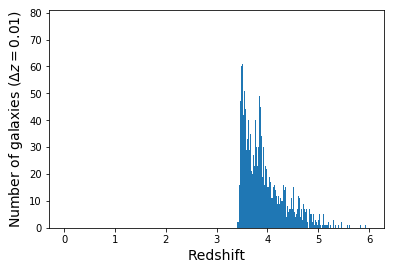

In [14]:
_ = plt.hist(outliers["z"], bins=np.arange(0, 6, 0.01))
plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Number of galaxies ($\Delta z=0.01$)", fontsize=14)